In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ga-customer-revenue-prediction/sample_submission.csv
/kaggle/input/ga-customer-revenue-prediction/train_v2.csv
/kaggle/input/ga-customer-revenue-prediction/test_v2.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission_v2.csv
/kaggle/input/ga-customer-revenue-prediction/train.csv
/kaggle/input/ga-customer-revenue-prediction/test.csv


In [2]:
import json
import pandas as pd


def load_df(csv_path='/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    df.drop(columns=['customDimensions', 'hits'], inplace=True)

    df = df.fillna({'totals_pageviews':0,
                    'totals_transactionRevenue':0,
                    'totals_pageviews':0})

    df['device_isMobile'] = df['device_isMobile'].astype(int)
    df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype(int)

    cat_col = df.select_dtypes(include='object').columns

    df[cat_col] = df[cat_col].astype(str)

    return df


df = load_df('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=100_000)


In [3]:
!pip install -q optuna

In [4]:
df.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,...,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,water bottle,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,nan,nan,nan,nan,nan,nan,nan
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,nan,True,nan,nan,nan,nan,nan,nan
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan


In [5]:
y = df['totals_transactionRevenue']
X = df.drop(columns='totals_transactionRevenue')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 60000 samples 	 60%
Test:  20000 samples 	 20%
Val:   20000 samples 	 20%


**Створення Pipeline**

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


# class CustomOrdinalEncoder(OrdinalEncoder):
#     def fit(self, X, y=None):
#         super().fit(X)
#         self.categories_ = [list(cat) + ['<unknown>'] for cat in self.categories_]
#         return self

#     def transform(self, X):
#         for i, cat in enumerate(self.categories_):
#             X[:, i] = [x if x in cat else '<unknown>' for x in X[:, i]]
#         return super().transform(X)

In [7]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

# числові ознаки
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

# категоріальні ознаки
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])

# об'єднання двох pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['date', 'visitId', 'visitNumber', 'visitStartTime', 'device_isMobile'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),...
       'trafficSource_adwordsClickInfo.criteriaParameters',
       'trafficSource_referralPath', 'trafficSource_isTrueDirect',
       'trafficSource_adContent', 'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd'],
      dtype='object'))])

**Попередня обробка даних**

In [8]:
# навчання препроцесора
X_train = preprocessor.fit_transform(X_train)


# обробка даних
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [9]:
from sklearn import metrics


def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  # 1. Визначення гіперпараметрів:

  params = {
        'objective': 'mse',
        'n_estimator': 30,
        'verbose': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

  # 2. Створення моделі LightGBMRegressor:

  model = lgb.LGBMRegressor(**params)

  # 3. Навчання моделі на тренувальному наборі даних:

  model.fit(X_train, y_train)

  # 4. Оцінка моделі на тестовому наборі даних:

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  # 5. Повернення значення метрики:
  return r2

In [10]:
import lightgbm as lgb
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING) # щоб не виводило інформацію про trial

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

In [11]:
print(f"найкраща метрика: {study.best_value}")

найкраща метрика: 0.3013833181435025


In [12]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 100,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_fraction=0.7942242245347901, bagging_freq=1,
              boosting_type='dart', feature_fraction=0.7193304928498654,
              lambda_l1=5.539107605968159e-06, lambda_l2=0.0017946499998253845,
              min_child_samples=88, n_estimator=100, num_leaves=188,
              verbose=-1)

In [13]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [14]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,1277140.09,1180779.76
RMSE,27682090.73,16530021.67
R2,0.26,0.30


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

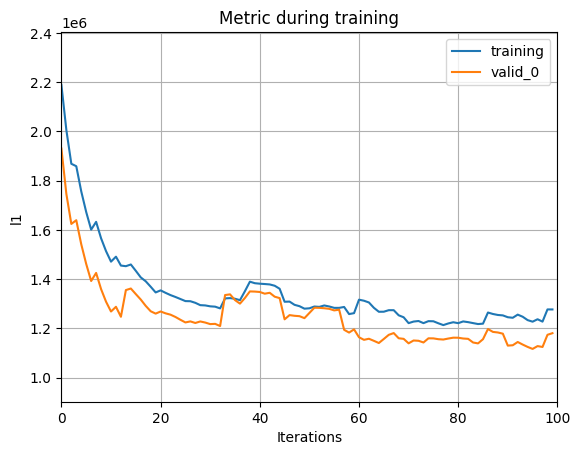

In [15]:
lgb.plot_metric(model,
                metric='l1')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

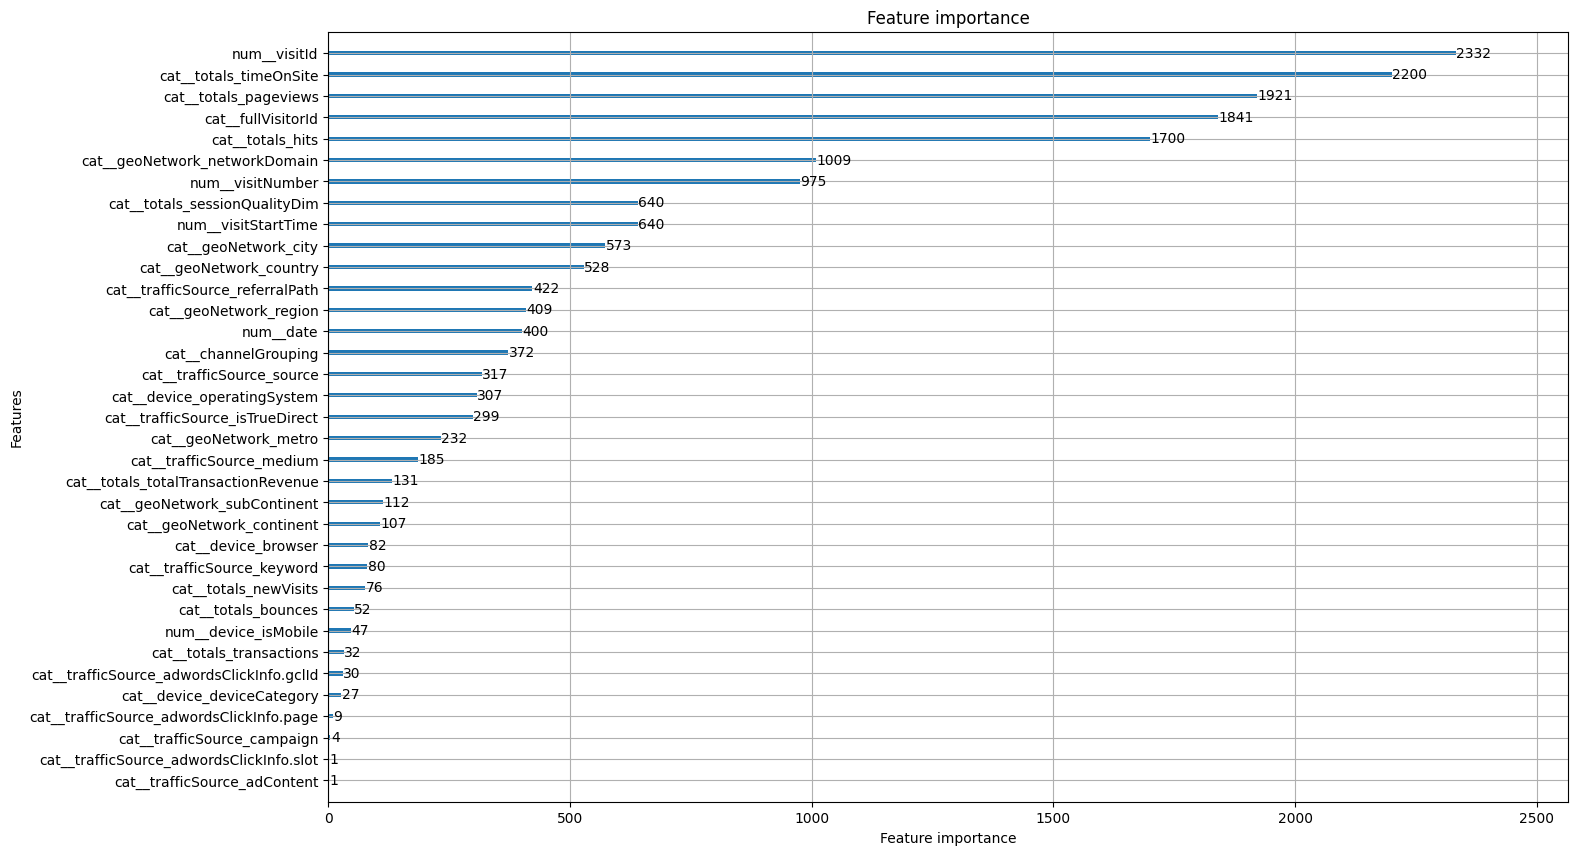

In [16]:
lgb.plot_importance(model, figsize=(16,10), max_num_features=40)